In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=gpu3'
import lasagne
import theano
import theano.tensor as T
floatX = theano.config.floatX



env: THEANO_FLAGS='device=gpu3'


Using gpu device 3: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [2]:
%load_ext autoreload
%autoreload 2

# [in development] this is just a minimalistic language model so far
# This tutorial explains the Generator agent type applied to conversation modelling
* experiment setup
* designing agent
* computing losses
* training

In [3]:
import cPickle
import numpy as np
with open("/home/jheuristic/yozhik/dl_s8/tokens.pcl") as fin:
    tokens = cPickle.load(fin)[0]

titles = np.load("/home/jheuristic/yozhik/dl_s8/titles.npy").astype("int32")

In [4]:
print ';'.join(tokens[:5])
print titles[:3,:10]
for title in titles[:10]:
    print ' '.join(map(tokens.__getitem__,title))

NULL;асфальтно;экусплуатации;препятствующую;рекордсервис
[[226421 488637 197907      0      0      0      0      0      0      0]
 [400357 375323      0      0      0      0      0      0      0      0]
 [467017 107402      0      0      0      0      0      0      0      0]]
toyota sera 1991 NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
монтаж кровли NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
костюм steilmann NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
ford focus 2011 NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
турбина 3 0 bar NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
ваз 2115 samara 2005 NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
ваз 2105 1998 NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL NULL
комната 12 м² в 3 к 3 14 эт NULL NULL NULL NULL NULL NULL
дом 42 м² на участке 7 сот NULL NULL NULL NULL NULL NULL NULL NULL
подголовники ваз 2109 NULL NULL NULL NULL NULL NULL NULL NULL N

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Generator
from agentnet.resolver import ProbablisticResolver

In [6]:

import lasagne
n_hid_1=2048 #first GRU memory
n_hid_2=2048 #second GRU memory
n_hid_3=128 #last "output" GRU memory
embedding_size=128
vocab_size = len(tokens) #number of words in dictionary



_observation_layer = lasagne.layers.InputLayer((None,1),name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer((None,n_hid_1),name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer((None,n_hid_2),name="prev_gru2_state_input")
_prev_gru3_layer = lasagne.layers.InputLayer((None,n_hid_3),name="prev_gru3_state_input")


emb = lasagne.layers.EmbeddingLayer(_observation_layer,vocab_size,embedding_size,name="token_vectors")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     emb,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

gru_1_and_2 = lasagne.layers.concat([gru1,gru2])

gru3 = GRUMemoryLayer(n_hid_3,
                     gru_1_and_2,        #note that it takes CURRENT gru1 and gru2 outputs as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru3_layer,
                     name="gru3")


concatenated_memory = lasagne.layers.concat([gru_1_and_2,gru3])


#policy


greed = theano.shared(np.float32(1),"prob_multiplier")



policy_layer = lasagne.layers.DenseLayer(gru3, #taking output gru layer. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                         num_units = vocab_size,
                                         nonlinearity=lambda x: lasagne.nonlinearities.softmax(x*greed),
                                         name="policy_original")

#resolver


resolver = ProbablisticResolver(policy_layer,assume_normalized=True,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _prev_gru3_layer:last_hidden[:,n_hid_1+n_hid_2:],
        _observation_layer:observation
    }

#all together
agent = Generator(concatenated_memory,policy_layer,resolver,input_map=custom_input_map
             )


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[token_vectors.W,
 gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 gru3.W_in_to_updategate,
 gru3.W_hid_to_updategate,
 gru3.b_updategate,
 gru3.W_in_to_resetgate,
 gru3.W_hid_to_resetgate,
 gru3.b_resetgate,
 gru3.W_in_to_hidden_update,
 gru3.W_hid_to_hidden_update,
 gru3.b_hidden_update,
 policy_original.W,
 policy_original.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]



In [8]:
seq_length = titles.shape[1]

sequences_batch = theano.shared(np.zeros([3,seq_length],dtype="int32"),name="reference_sequences")

batch_size = sequences_batch.shape[0]

history = agent.get_sessions(session_length=seq_length,
                             recorded_sequence=sequences_batch,
                             batch_size=batch_size,)

hidden_seq,policy_seq,action_seq = history

In [9]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history,mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [10]:
predicted_probas = policy_seq.reshape([-1,vocab_size])
predicted_probas = T.maximum(predicted_probas,1e-5)

model_loss = lasagne.objectives.categorical_crossentropy(predicted_probas,
                                                         sequences_batch.ravel()).mean()

In [11]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [12]:
loss = model_loss + reg_l2

#### Compute weight updates

In [13]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss],updates=updates)

evaluation_fun = theano.function([],[loss,model_loss,reg_l2])

In [ ]:
log = ""

In [ ]:
loss_seq = []
for i in range(50000):
    new_batch = titles[np.random.randint(len(titles),size=10)]
    sequences_batch.set_value(new_batch)
    
    loss_seq.append(train_fun())
    
    if i % 100==0:
        quality = "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,evaluation_fun()))        
        print quality
        log+=quality+'\n'
        
        examples = get_history()[-1][:3]
        for tid_line in examples:
            line = ' '.join(map(tokens.__getitem__,tid_line))
            print line
            log += line+'\n'

    

iter:0	full:420.00287	llh:11.51293	reg:408.48993
динамио 16248 нацеленный поклейщик непредвиденным el10 муранка 0002709 рожающая уточные юридичeской 35890 seminyak 1632мб атибукс
tatu ближaйшaя феодосии боллеров камеди nicam matera отрежем 28813 aist брусковый росрао видоизменять водолазок рыльца
джипа полар2 crestliner набойках восхищают 10лир1973 пиявок 3000х1350 чемодане пользуясь дарение 41261 беспомощным акварио подстричься
iter:100	full:403.99347	llh:11.51293	reg:392.48053
отбалансирую медсестринских окупать продавайте лётный аон¹ rw6815 шредеръ u180 магaзине 69в 3325 наемные светлеет литор
новосиб олицетворение шезлог евроконтейнер mb110rs igel 660000р ухожиные 170413 докембрийскую 1460т glissee маломощное coaxial грубую
спиридонова белорус nbp nexi честер обоюдный дмц черокманова sf9 выразительным летом13г щебеночный обечайку fera ктпто
iter:200	full:388.60242	llh:11.51293	reg:377.08948
брянская умирающий гapaнтируем абба термочаши 33т обменен ру63 супрафил перемешивающим ооч в

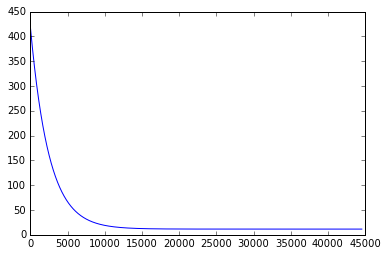

In [17]:
plt.plot(loss_seq)

In [18]:
print log[-1000:]

ированный запонки алeкceевкa seduction
iter:44400	full:11.51293	llh:11.51293	reg:0.00001
4kg цветное раздвинутый ассиметричного фyнкционируют актированны огниково roudnitska cлать потению бобкета смените сохранном 375руб 13077
bde pc2100r 55713 1000173 дымников соленойды описывающий smarttouch страховкой налоговыми свдьбу тяжелейший котлованный лазаря бессмертие
активную bone акушинского маторами 20x76 перезаправляемого таккак заводчиками назвать повестки высокоразвитая оценкованное аpeнде биржевое пространства
iter:44500	full:11.51293	llh:11.51293	reg:0.00001
королевстве захватывая админестратора цоп биаксиальная запасу вкючено 1core тугулымский конго seevoll упаковочных электротеном включении засыпания
аборт амортизирующего корс диагональ10 shade подключеные 7j17 уменьшенную затенять оксиданты дрожащего истринский peгиcтрaция homestar муcоропpовод
обязаннoсти мощность миксфайт рыбно карциномы dikson донлоп нагретом 27х25 md103ll вольтамперфазометры болоне ротбанда 540см длинномерный


In [19]:
from agentnet.utils.persistence import save

save(resolver,"lm-gru.pcl")

In [ ]:
loss_seq